In [1]:
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE

In [2]:
os.chdir('..')

In [3]:
import importlib
from Orange.evaluation import scoring
_ = importlib.reload( scoring )

from analysis.auto_report import AutoSummaryReport

In [4]:
exp_name_map = {
    'DummyEncoder_': '',
    'SimpleReweight': 'No reweight,',
    'StaticGridWeighter': 'static optimal',
    'LiltabEncoder': 'liltab,',
    'DirectionReweight': 'Direction reweight,',
    'SoftMaxWeighter': 'Softmax',
    'MLPEncoder': 'MLP,',
    'OneHotWeighter': 'One Takes All',
    'StaticEqualWeighter': 'static equal',
    '_': ' '
}

def change_exp_name(exp_name, mapping=exp_name_map):
    for key, item in mapping.items():
        exp_name = exp_name.replace(key, item)
    
    return exp_name 

In [5]:
path = 'report/first_scenario_full'
report = AutoSummaryReport(path)
metrics = report.get_metrics()

In [20]:
experiments_names = [
    'DummyEncoder_SimpleReweight_StaticGridWeighter',
    'DummyEncoder_SimpleReweight_StaticEqualWeighter',
    'LiltabEncoder_DirectionReweight_OneHotWeighter',
    'LiltabEncoder_DirectionReweight_SoftMaxWeighter',
    'LiltabEncoder_SimpleReweight_OneHotWeighter',
    'LiltabEncoder_SimpleReweight_SoftMaxWeighter',
    'MLPEncoder_DirectionReweight_OneHotWeighter',
    'MLPEncoder_DirectionReweight_SoftMaxWeighter',
    'MLPEncoder_SimpleReweight_OneHotWeighter',
    'MLPEncoder_SimpleReweight_SoftMaxWeighter'
]

custom_solutions = [
    'LiltabEncoder_DirectionReweight_OneHotWeighter',
    'LiltabEncoder_DirectionReweight_SoftMaxWeighter',
    'LiltabEncoder_SimpleReweight_OneHotWeighter',
    'LiltabEncoder_SimpleReweight_SoftMaxWeighter',
    'MLPEncoder_DirectionReweight_OneHotWeighter',
    'MLPEncoder_DirectionReweight_SoftMaxWeighter',
    'MLPEncoder_SimpleReweight_OneHotWeighter',
    'MLPEncoder_SimpleReweight_SoftMaxWeighter'
]

best_methods = [
    # 'MLPEncoder_DirectionReweight_SoftMaxWeighter',
    'LiltabEncoder_DirectionReweight_SoftMaxWeighter',
]

data_names = np.unique(metrics[metrics['experiment_name'] == 'LiltabEncoder_DirectionReweight_SoftMaxWeighter']['data_name'])

In [21]:
acc_b = metrics[metrics['metric'] == 'acc-b']
acc_b = acc_b[acc_b['data'] == 'test']
acc_b = acc_b[acc_b['experiment_name'].isin(experiments_names)]
acc_b = acc_b[acc_b['data_name'].isin(data_names)]

baseline = acc_b[acc_b['experiment_name'] == 'DummyEncoder_SimpleReweight_StaticEqualWeighter']
baseline_sota = acc_b[acc_b['experiment_name'] == 'DummyEncoder_SimpleReweight_StaticGridWeighter']

acc_b_best = acc_b[acc_b['experiment_name'].isin(best_methods)]


acc_b['experiment_name'] = acc_b['experiment_name'].apply(change_exp_name)
baseline['experiment_name'] = baseline['experiment_name'].apply(change_exp_name)
acc_b_best['experiment_name'] = acc_b_best['experiment_name'].apply(change_exp_name)

acc_b['rank'] = acc_b.groupby("data_name")["score"].rank(method="dense", ascending=False)
avg_ranks = acc_b.groupby('experiment_name')['rank'].mean()
avg_ranks.index

/tmp/ipykernel_18590/3597323675.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline['experiment_name'] = baseline['experiment_name'].apply(change_exp_name)
/tmp/ipykernel_18590/3597323675.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_b_best['experiment_name'] = acc_b_best['experiment_name'].apply(change_exp_name)


Index(['MLP, Direction reweight, One Takes All',
       'MLP, Direction reweight, Softmax', 'MLP, No reweight, One Takes All',
       'MLP, No reweight, Softmax', 'No reweight, static equal',
       'No reweight, static optimal',
       'liltab, Direction reweight, One Takes All',
       'liltab, Direction reweight, Softmax',
       'liltab, No reweight, One Takes All', 'liltab, No reweight, Softmax'],
      dtype='object', name='experiment_name')

In [22]:
(acc_b_best[acc_b_best['experiment_name'] == 'liltab, Direction reweight, Softmax']['score'] - baseline['score']).max()

0.17651023320222625

In [23]:
(acc_b_best[acc_b_best['experiment_name'] == 'liltab, Direction reweight, Softmax']['score'] - baseline['score']).mean()

0.012235519092264136

In [24]:
(acc_b_best[acc_b_best['experiment_name'] == 'liltab, Direction reweight, Softmax']['score'] - baseline_sota['score']).max()

0.02813390313390307

In [30]:
(acc_b_best[acc_b_best['experiment_name'] == 'liltab, Direction reweight, Softmax']['score'] - baseline_sota['score']).mean()

0.00042440765972327597

# CD plots

In [11]:
avg_ranks

experiment_name
MLP, Direction reweight, One Takes All        7.26
MLP, Direction reweight, Softmax              6.44
MLP, No reweight, One Takes All               7.48
MLP, No reweight, Softmax                     7.60
No reweight, static equal                    10.28
No reweight, static optimal                   6.44
liltab, Direction reweight, One Takes All     7.32
liltab, Direction reweight, Softmax           5.88
liltab, No reweight, One Takes All            7.16
liltab, No reweight, Softmax                  7.64
Name: rank, dtype: float64

/tmp/ipykernel_18590/2897704465.py:4: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = scoring.compute_CD(avranks, datasets_n, alpha="0.1")
/tmp/ipykernel_18590/2897704465.py:6: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  scoring.graph_ranks(avranks, names, cd, width=6, textspace=1.5)


2.5004435539257295


Text(0.5, 1.0, 'Critical Distance - comparison of the methods ranks')

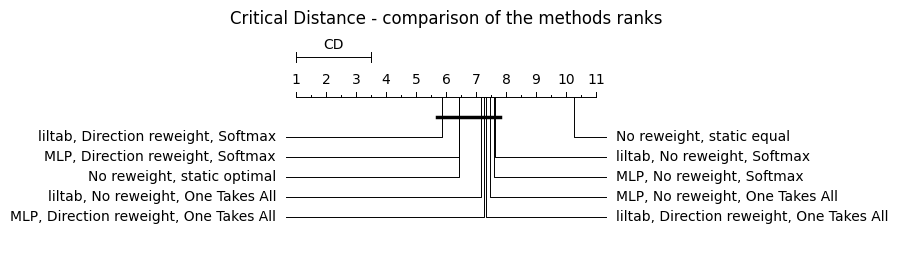

In [12]:
names = avg_ranks.index.tolist()
avranks =  avg_ranks.values.tolist()
datasets_n = np.unique(acc_b['data_name']).shape[0]
cd = scoring.compute_CD(avranks, datasets_n, alpha="0.1")
print(cd)
scoring.graph_ranks(avranks, names, cd, width=6, textspace=1.5)
plt.title('Critical Distance - comparison of the methods ranks')


# Gain comparison

In [13]:
comp = pd.merge(acc_b, baseline, on='data_name')
comp['diff'] = comp['score_x'] - comp['score_y']
comp = comp[comp['experiment_name_x'] != 'No reweight, static equal']

names = np.unique(comp['experiment_name_x'].sort_values())
colors = []
for name in names:
    if 'static' in name:
        color = '#D4E09B'
    elif 'liltab' in name:
        color = '#A44A3F'
    else:
        color = '#F19C79'
    colors.append(color)

/tmp/ipykernel_18590/1410839076.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=comp.sort_values('experiment_name_x'), y='experiment_name_x', x='diff', palette=colors)


Text(0.5, 1.0, 'Gain in balanced accuracy, comparing to equal weights approach\nComputed on test dataset')

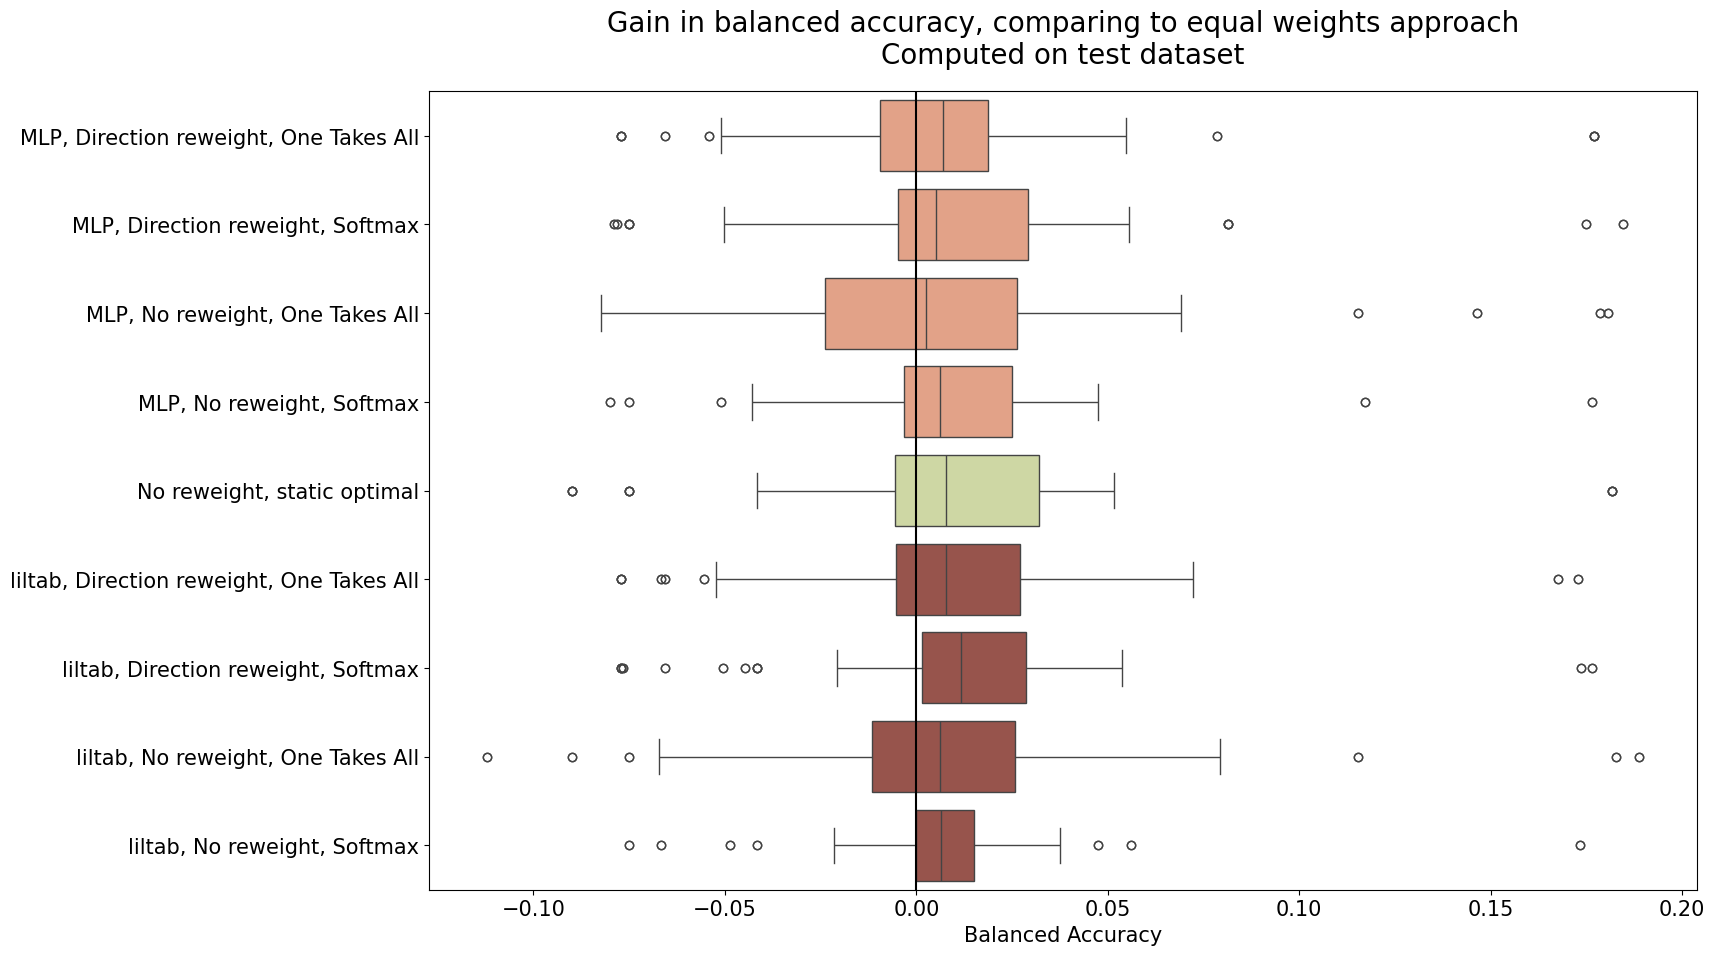

In [14]:
plt.figure(figsize=(16, 9))

sns.boxplot(data=comp.sort_values('experiment_name_x'), y='experiment_name_x', x='diff', palette=colors)
plt.xticks(rotation=90)
plt.tight_layout()
plt.axvline(0, color='black')
plt.xlabel('Balanced Accuracy', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=0)
plt.ylabel('', fontsize=15)
plt.title('Gain in balanced accuracy, comparing to equal weights approach\nComputed on test dataset', fontsize=20, pad=20)


# liltab vs MLP

In [15]:
liltab = acc_b[acc_b['experiment_name'].str.contains('liltab')]
liltab['experiment_name'] = liltab['experiment_name'].str[8:]

mlp = acc_b[acc_b['experiment_name'].str.contains('MLP')]
mlp['experiment_name'] = mlp['experiment_name'].str[5:]

comp = pd.merge(liltab, mlp, on=['experiment_name', 'data_name'])
comp['diff'] = comp['score_x'] - comp['score_y']

/tmp/ipykernel_18590/1103386022.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  liltab['experiment_name'] = liltab['experiment_name'].str[8:]
/tmp/ipykernel_18590/1103386022.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mlp['experiment_name'] = mlp['experiment_name'].str[5:]


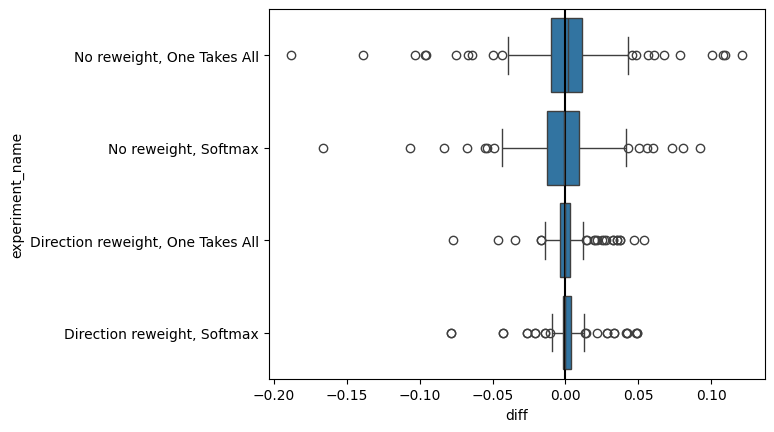

In [16]:
sns.boxplot(comp, x='diff', y='experiment_name')

plt.axvline(0, color='black')


# Best method vs SoTA

In [25]:
comp = pd.merge(acc_b_best, baseline_sota, on='data_name')
comp['diff'] = comp['score_x'] - comp['score_y']

names = np.unique(comp['experiment_name_x'].sort_values())
for name in names:
    if 'static' in name:
        color = '#D4E09B'
    elif 'liltab' in name:
        color = '#A44A3F'
    else:
        color = '#F19C79'
    colors.append(color)

/tmp/ipykernel_18590/3852920774.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(data=comp.sort_values('experiment_name_x'), y='experiment_name_x', x='diff', showmeans=True, meanline=True, palette=colors)
/tmp/ipykernel_18590/3852920774.py:3: UserWarning: The palette list has more values (12) than needed (1), which may not be intended.
  g = sns.boxplot(data=comp.sort_values('experiment_name_x'), y='experiment_name_x', x='diff', showmeans=True, meanline=True, palette=colors)


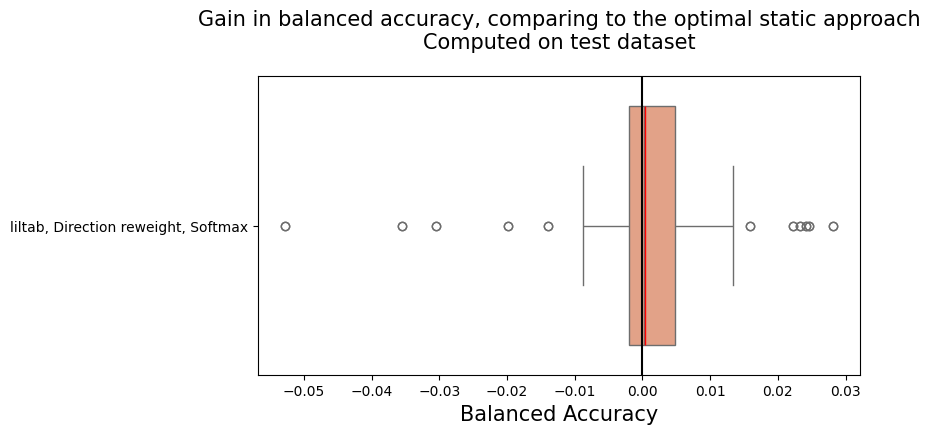

In [29]:
plt.figure(figsize=(9, 4))

g = sns.boxplot(data=comp.sort_values('experiment_name_x'), y='experiment_name_x', x='diff', showmeans=True, meanline=True, palette=colors)
plt.xticks(rotation=90)
plt.tight_layout()
plt.axvline(0, color='black')
plt.xlabel('Balanced Accuracy', fontsize=15)
plt.ylabel('Method', fontsize=15)
plt.title('Gain in balanced accuracy, comparing to the optimal static approach\nComputed on test dataset', fontsize=15, pad=20)

plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=0)
plt.ylabel('', fontsize=15)

ax = plt.gca()
mean_lines = [line for line in ax.lines if line.get_linestyle() == '--']

for i in range(len(mean_lines)):
    mean_lines[i].set_color('red')
    mean_lines[i].set_linestyle('-')

plt.show()

# Weights diff norm

In [19]:
weights_metrics = report.get_weights_metrics()
weights_metrics = weights_metrics[weights_metrics['experiment_name'].isin(custom_solutions)]
weights_metrics['experiment_name'] = weights_metrics['experiment_name'].apply(change_exp_name)
weights_metrics = weights_metrics.sort_values('experiment_name')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [54]:
names = np.unique(weights_metrics['experiment_name'].sort_values())
colors = []
for name in names:
    if 'Softmax' in name:
        color = '#A44A3F'
    else:
        color = '#F19C79'
    colors.append(color)

/tmp/ipykernel_13143/4097062954.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=weights_metrics, x='norm', y='experiment_name', palette=colors)


Text(-224.52777777777777, 0.5, 'Method')

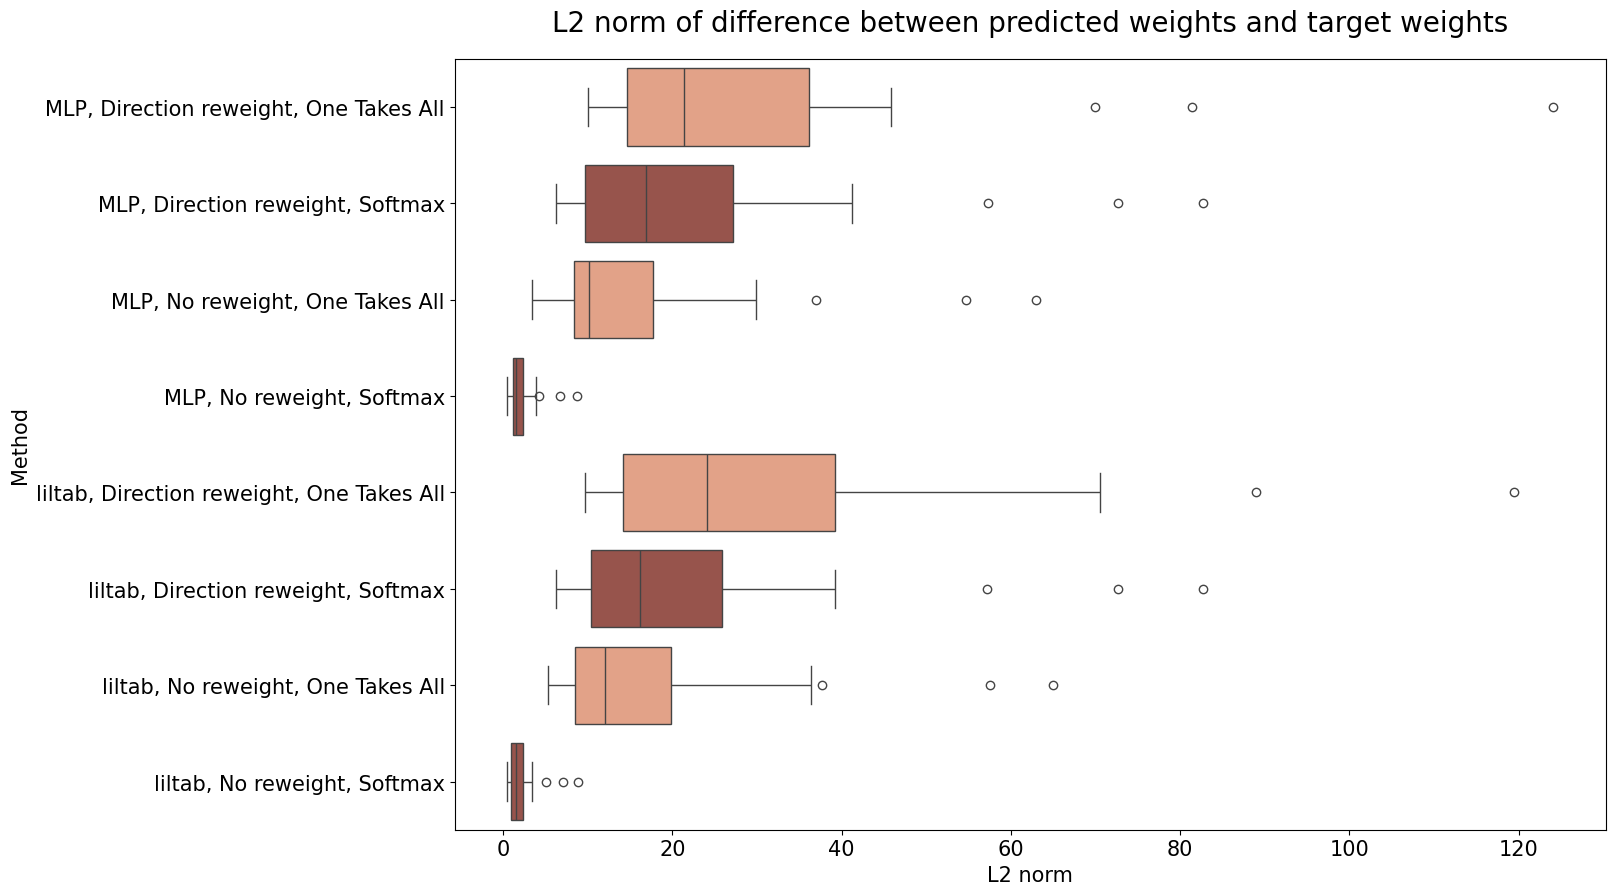

In [56]:
plt.figure(figsize=(16, 9))

sns.boxplot(data=weights_metrics, x='norm', y='experiment_name', palette=colors)
plt.title('L2 norm of difference between predicted weights and target weights', fontsize=20, pad=20)

plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=0)
plt.ylabel('', fontsize=15)

plt.tight_layout()
plt.xlabel('L2 norm', fontsize=15)
plt.ylabel('Method', fontsize=15)

/tmp/ipykernel_13143/2611449049.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=weights_metrics, x='std', y='experiment_name', palette=colors)


Text(0.5, 1.0, 'Diversity of chosen weights, measured with STD')

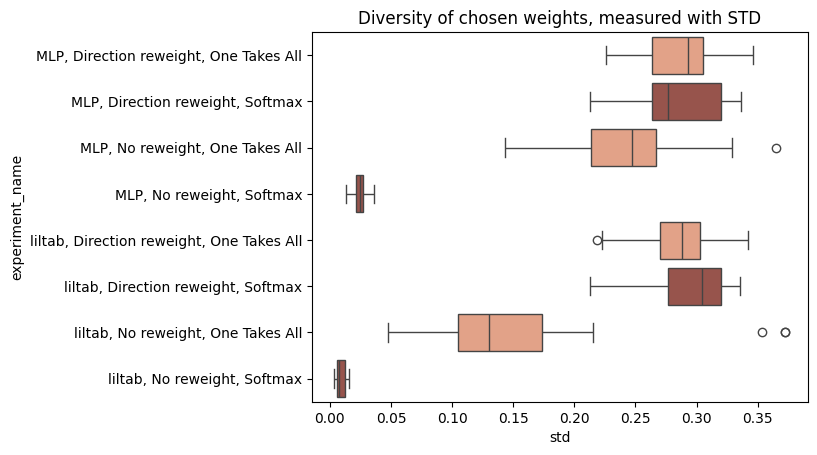

In [19]:
sns.boxplot(data=weights_metrics, x='std', y='experiment_name', palette=colors)
plt.title('Diversity of chosen weights, measured with STD')

In [20]:
weights = report.get_weights()
weights = weights[weights['experiment_name'].isin(custom_solutions)]
weights = weights[weights['type'] =='test_weights']

weights_ = weights.to_numpy()[:,1:-3]
weights_.shape

(382008, 6)

In [ ]:
tsne = TSNE(n_iter=250)
tsne_projection = tsne.fit_transform(weights_)

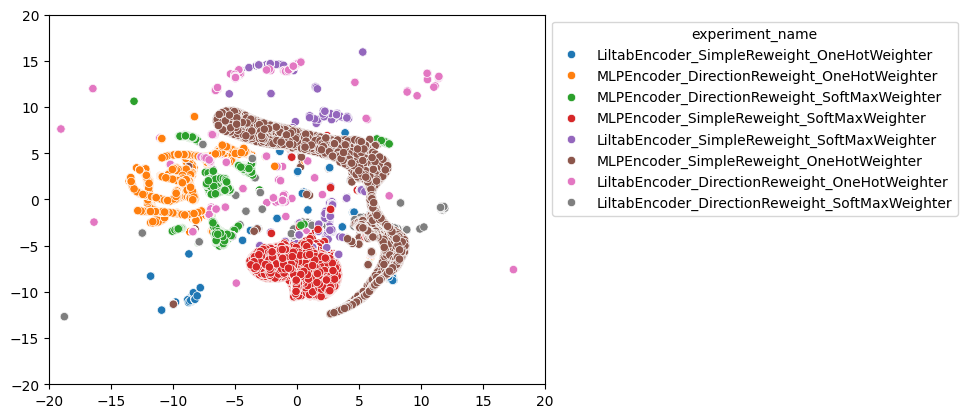

In [19]:
ax = sns.scatterplot(x=tsne_projection[:,0], y=tsne_projection[:,1], hue=weights['experiment_name'])
plt.xlim((-20, 20))
plt.ylim((-20, 20))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))